# Using Bayesian Network to predict if a song of Spotify will be an hit or not

## Data and preprocessing
The dataset is taken from [Kaggle - London bike sharing dataset](https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset).

This dataset contains 17414 entries. Each entry represents the bike rental data for the city of London at an interval of 1 hour. The data was collected between the 1st of April 2015 and the 1st of March 2017.
The dataset reports the following features for each entry:
 - **timestamp**: time of the collected data;
 - **cnt**: the amount of bike sharing rides in the specified interval;
 - **t1**: the registered temperature measured in Celsius degrees;
 - **t2**: the perceived temperature;
 - **hum**: registered humidity in percentage;
 - **windspeed**: wind speed measured as km/h;
 - **weather_code**: the weather category: 1=Clear, 2=Scattered Clouds, 3=Broken Clouds, 4=Cloudy, 7=Rain, 10= Rain with Tunderstorm, 26=Snowfall;
 - **is_holiday**: True if the day of the entry is an holiday, False otherwise;
 - **is_weekend**: True if the day of the entry is in the weekend, False otherwise;
 - **season**: season of the year: 0=Spring, 1=Summer, 2=Fall, 3=Winter;


TODO add some data analysis

## Preprocessing
Before constructing the network we need to preprocess the data in order to:
 1. Disretize continuous features, since pmgpy does not support continuous variables
 2. Make the features range smaller, to reduce the RAM needed by pgmpy to generate the network. This can be done by transform values in deciles.


In [1]:
pip install pgmpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = 'drive/MyDrive/'
else:
    data_dir = ''

In [7]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion

In [4]:
df = pd.read_csv(data_dir + "london_merged.csv")
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

Dataset contains 17414 rows and 10 columns


,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [34]:
#data = df.drop(columns=['timestamp']).dropna()
data = df.copy().dropna()
#TODO tenere il timestamp e controllare come cambia con il giorno e l'ora 
def tday(h):
    if h == None:
        print('aaa')
    time_of_day = None
    if h < 7:
        time_of_day = 0
    elif h >= 7 and h < 13:
        time_of_day = 1
    elif h >= 13 and h < 19:
        time_of_day = 2
    elif h >= 19:
        time_of_day = 3
        
    return time_of_day

data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['hour'] = data['timestamp'].apply(lambda x: int(tday(x.hour)))
data = data.drop(columns='timestamp').dropna()
data['is_holiday'] = data['is_holiday'].apply(lambda x: bool(x))
data['is_weekend'] = data['is_weekend'].apply(lambda x: bool(x))
data['season'] = data['season'].apply(lambda x: int(x))
data['cnt'] = data['cnt'].apply(lambda x: int(x))
data['weather_code'] = data['weather_code'].apply(lambda x: int(x))

# Transformation in deciles
for col in ('t1', 't2', 'hum', 'wind_speed', 'cnt'):
    bins = pd.qcut(df[col], q=4, duplicates='drop')
    bin2int = {x: i for i, x in enumerate(bins.dtype.categories)}
    data[col] = bins.apply(lambda x: bin2int[x]).astype(np.uint8)

In [15]:
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
0,0,0,0,3,0,3,False,True,3,0
1,0,0,0,3,0,1,False,True,3,0
2,0,0,0,3,0,1,False,True,3,0
3,0,0,0,3,0,1,False,True,3,0
4,0,0,0,3,0,1,False,True,3,0


## Network definition

In [16]:
data.columns

Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season', 'hour'],
      dtype='object')

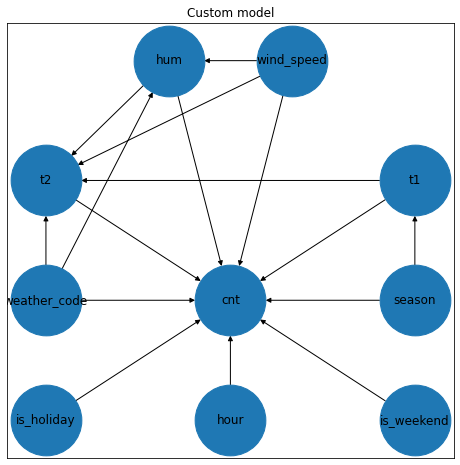

In [17]:
from pgmpy.models import BayesianNetwork

custom_model = BayesianNetwork([('t1', 'cnt'), ('t2', 'cnt'), ('hum', 'cnt'), ('wind_speed', 'cnt'),
                              ('weather_code', 'cnt'), ('is_holiday', 'cnt'), ('is_weekend', 'cnt'),
                              ('season', 'cnt'), ('hour','cnt'),
                              ('t1','t2'), ('hum', 't2'), ('wind_speed', 't2'), ('weather_code', 't2'),
                              ('season', 't1'), ('weather_code', 't2'),
                              ('wind_speed', 'hum'), ('weather_code', 'hum')])

pos = {'cnt': [0, 1], 't1': [1.5, 1.5], 't2': [-1.5, 1.5], 'hum': [-0.5,  2],
       'wind_speed': [0.5,  2], 'weather_code': [-1.5, 1], 'is_holiday': [-1.5, 0.5],
       'is_weekend': [1.5, 0.5], 'season': [1.5,  1], 'hour': [0, 0.5]}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(custom_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Custom model')
fig.savefig('custom_bn')


To make sense of the data we can use pmgpy to count how often some variable occurs:

In [18]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(custom_model, data)
print("\n", pe.state_counts('t1'))


 season       0       1       2       3
t1                                    
0       1344.0     0.0   554.0  2497.0
1       1753.0   179.0  1358.0  1266.0
2        886.0  1092.0  1596.0   565.0
3        411.0  3116.0   795.0     2.0


We can then use a Maximum Likelihood Estimation to estimate the CPDs for the defined network: 

In [19]:
from pgmpy.estimators import MaximumLikelihoodEstimator
custom_model.fit(data, estimator=MaximumLikelihoodEstimator)
print(custom_model.get_cpds(node='t1'))

KeyboardInterrupt: 

MLE tends to overfit on the data. For example we see that the probability of having a temperature in the 5 quantile during winter is considered 0. Even if very unlikely, we know that this is possible.
A way to overcome this problem is to use a Bayesian Estimator, with some prior:

In [20]:
from pgmpy.estimators import BayesianEstimator

bes = BayesianEstimator(custom_model, data)
custom_model.fit(data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
print(custom_model.get_cpds(node='t1'))

+--------+---------------------+-----+-----------------------+
| season | season(0)           | ... | season(3)             |
+--------+---------------------+-----+-----------------------+
| t1(0)  | 0.30583987262595247 | ... | 0.5764858626658973    |
+--------+---------------------+-----+-----------------------+
| t1(1)  | 0.3988684180598203  | ... | 0.2923542989036353    |
+--------+---------------------+-----+-----------------------+
| t1(2)  | 0.2016660980325259  | ... | 0.1305539526832083    |
+--------+---------------------+-----+-----------------------+
| t1(3)  | 0.09362561128170135 | ... | 0.0006058857472590883 |
+--------+---------------------+-----+-----------------------+


The estimated CPDs are now more "conservative", for example the estimate of having the temperature in the 5th quantile during winter is 0.001.

This network sums up our knowledge about the data.

## Learning the network structure

pgmpy offers also the possibility of learning the network structure from the data.

/home/carlo/.local/lib/python3.8/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


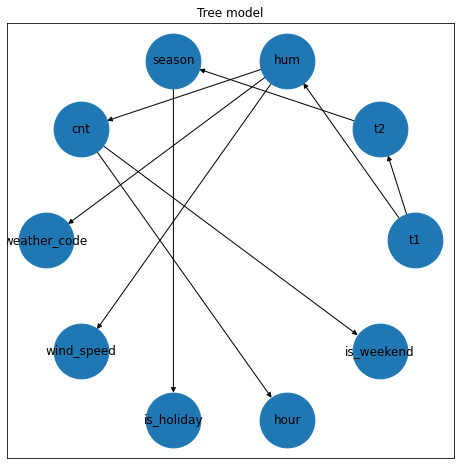

In [21]:
ts = TreeSearch(data=data, root_node='t1')
tree_model = ts.estimate(show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=3000)
fig.savefig('tree')
ax.set_title('Tree model')
tree_model = BayesianModel(tree_model.edges())

The tree serach is an easy way to generate a network, but due to the nature of the problem, wgich makes difficoult to choose a root, it does not return good results. Changing the root we obtain similar results, so we need more complex algorithms, like HillCLimb Search.

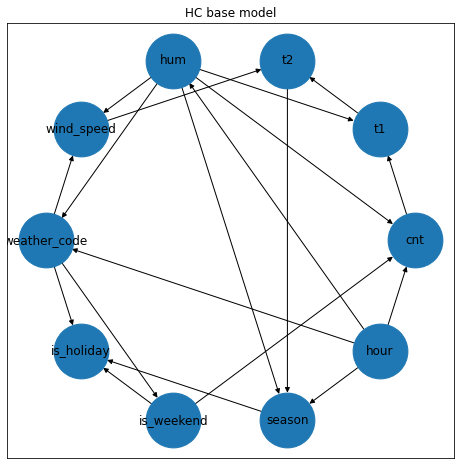

In [55]:
scorer = BDeuScore(data=data)
hc = HillClimbSearch(data=data)
hc_base_model = hc.estimate(scoring_method=scorer, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(hc_base_model, pos=nx.drawing.layout.circular_layout(hc_base_model), ax=ax, node_size=3000)
fig.savefig('hc_base')
ax.set_title('HC base model')
hc_base_model = BayesianNetwork(hc_base_model.edges())

There seems to be some problems with this network:
- cnt can not contribute to other features
- There are also some dependencies, that we know to be true, that are missing:
    - humidity -> perceived temperature

All these problems will be solved applying some constraints.

The model seems to be too complex to estimate, we drop some columns that do not seem to affect the output significantly

In [50]:
data_small = data.drop(columns=['season'])

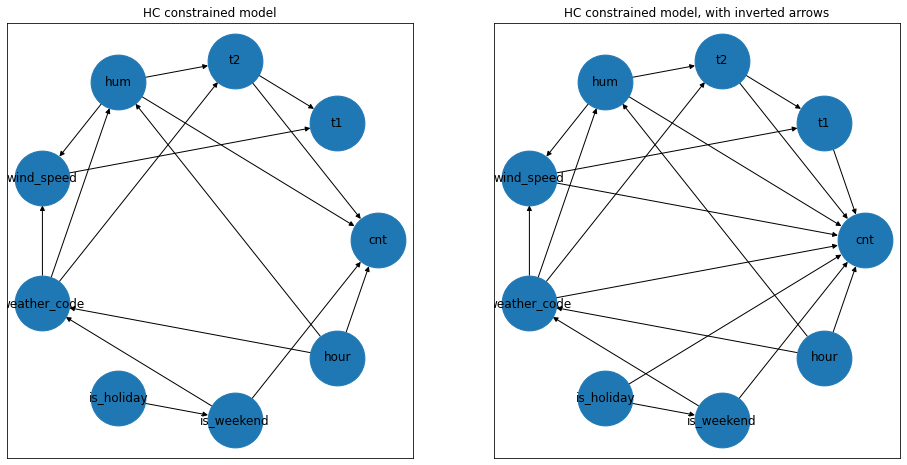

In [51]:
fixed_edges = [('hum', 't2'),]

# On_chart cannot be the cause of anything
black_list = [('cnt', c) for c in data.columns]

scorer = BDeuScore(data=data_small)
hc = HillClimbSearch(data=data_small)
hc_constr_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list, show_progress=False)

fixed_edges += [(c, 'cnt') for c in ['t2', 'hum', 'wind_speed', 'weather_code', 'is_weekend','hour','t1','is_holiday']]
hc_inv_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list, show_progress=False)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
nx.draw_networkx(hc_constr_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax[0], node_size=3000)
nx.draw_networkx(hc_inv_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax[1], node_size=3000)
ax[0].set_title('HC constrained model')
ax[1].set_title('HC constrained model, with inverted arrows')

hc_constr_model = BayesianNetwork(hc_constr_model.edges())
hc_inv_model = BayesianNetwork(hc_inv_model.edges())




In [56]:
# The tree model seems inaccurate, so it is omitted, too
hc_base_model.fit(data, estimator=MaximumLikelihoodEstimator)
print("Done")
hc_constr_model.fit(data, estimator=MaximumLikelihoodEstimator)
print("Done")
hc_inv_model.fit(data, estimator=MaximumLikelihoodEstimator)
print("Done")

Done
Done
Done


In [48]:
from pgmpy.estimators import BDeuScore, K2Score, BicScore


bdeu = BDeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)


print("Scores for the custom model")
print(bdeu.score(custom_model))
print(k2.score(custom_model))
print(bic.score(custom_model))
print("Scores for the model defined with basic hill climb")
print(bdeu.score(hc_base_model))
print(k2.score(hc_base_model))
print(bic.score(hc_base_model))
print("Scores for the model defined with hill climb and with our constraints")
print(bdeu.score(hc_constr_model))
print(k2.score(hc_constr_model))
print(bic.score(hc_constr_model))
print("Scores for the model defined with hill climb and inverted dependencies????")
print(bdeu.score(hc_inv_model))
print(k2.score(hc_inv_model))
print(bic.score(hc_inv_model))

Scores for the custom model
-190986.44128411953
-174365.79269358583
-1847626.7868543547
Scores for the model defined with basic hill climb
-140486.3999309595
-140143.1425657681
-140785.12602752962
Scores for the model defined with hill climb and with our constraints
-144436.98211449623
-143784.955563847
-145318.0967167384
Scores for the model defined with hill climb and inverted dependencies????
-160337.94022919517
-146828.87570154888
-560189.52266425


In [57]:
models = [{'name': 'custom model', 'model': custom_model, 'nodes': data.columns.values.tolist()},
          {'name': 'HC base model', 'model': hc_base_model, 'nodes': data.columns.values.tolist()},
          {'name': 'HC constr model', 'model': hc_constr_model, 'nodes': data_small.columns.values.tolist()},]

for model in models:
  print('Considering model:', model['name'])
  print('Considering nodes:', model['nodes'])
  print(f"The total number of valid independence assertions is {len(model['model'].get_independencies().get_assertions())}")
  print(f"Local semantics of the current model:\n{model['model'].local_independencies(model['nodes'])}")
  print('Checking Markov blankets')
  for node in model['nodes']:
    print(f"The Markov blanket of node {node} is {model['model'].get_markov_blanket(node)}")
  print()

Considering model: custom model
Considering nodes: ['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season', 'hour']
The total number of valid independence assertions is 2203
Local semantics of the current model:
(t1 ⟂ is_weekend, is_holiday, hour, wind_speed, hum, weather_code | season)
(t2 ⟂ season, is_weekend, is_holiday, hour | t1, weather_code, hum, wind_speed)
(hum ⟂ is_weekend, is_holiday, season, hour, t1 | weather_code, wind_speed)
(wind_speed ⟂ is_weekend, is_holiday, season, hour, t1, weather_code)
(weather_code ⟂ is_weekend, is_holiday, season, hour, wind_speed, t1)
(is_holiday ⟂ is_weekend, wind_speed, t1, hum, weather_code, season, t2, hour)
(is_weekend ⟂ wind_speed, t1, hum, weather_code, season, t2, is_holiday, hour)
(season ⟂ is_weekend, is_holiday, hour, wind_speed, hum, weather_code)
(hour ⟂ is_weekend, wind_speed, t1, hum, weather_code, season, is_holiday, t2)
Checking Markov blankets
The Markov blanket of node cnt is ['is_weeken

## Performing inferences

### Hill climb constr model

In the hill climb constr model the features that directly influence cnt are:
 - t2, range {0,...,3},
 - hum, range {0,...,3},
 - is_weekend, range {True, False}
 - hour, range {0,...,3}

Let's see how they influence it.

In [81]:
inference = VariableElimination(hc_constr_model)

In [84]:
answers_t1 = []
answers_t2 = []
answers_hum = []
answers_wind_speed = []
answers_weather_code = []
answers_is_holiday = []
answers_is_weekend = []
answers_season = []
answers_hour = []

for score in range(4):
    for feature, answers in [('t2', answers_t2),
                            ('hum', answers_hum),
                            ('hour', answers_hour),]:
        evidence = {feature : score}
        answers.append(inference.query(["cnt"], evidence, show_progress=False).values[1])

for score in (True, False):
    for feature, answers in [('is_weekend', answers_is_weekend)]:
        evidence = {feature : score}
        answers.append(inference.query(["cnt"], evidence, show_progress=False).values[1])


[Text(0, 0, 'weekend'), Text(1, 0, 'no weekend')]

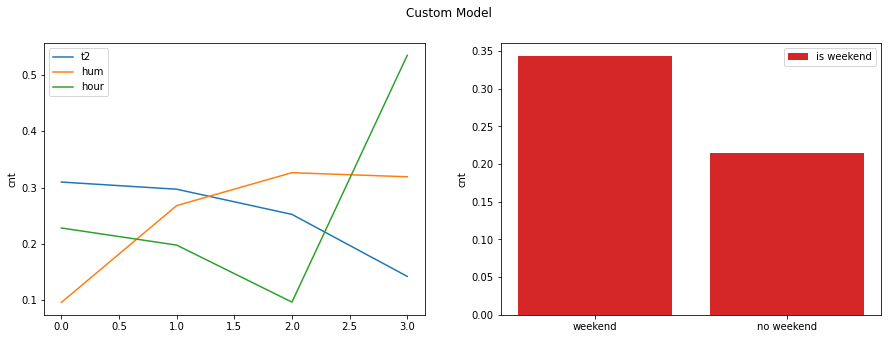

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
fig.suptitle(f"Custom Model")
ax.set_ylabel('cnt')
ax.plot(answers_t2, label='t2')
ax.plot(answers_hum, label='hum')
ax.plot(answers_hour, label='hour')
ax.legend()
ax2 = axes[1]
ax2.bar(range(2), answers_is_weekend, label='is weekend', color='C3')
ax2.legend()
ax2.set_ylabel('cnt')
ax2.set_xticks(range(2))
ax2.set_xticklabels(['weekend', 'no weekend'])

TODO comments

Now, what happens if we fix that our track has vocals?

In [91]:
answers = [[[] for _ in range(4)] for _ in range(4)]
for t2 in range(4):
  for hum in range(4):
    for hour in range(4):
      evidence = {"t2": t2, "hum": hum, 'is_weekend': True, 'hour': hour}
      answers[t2][hum].append(inference.query(["cnt"], evidence, show_progress=False).values[1])

In [92]:
def plot3d(X, Y, Z, xlabel, ylabel, zlabel, title):
  fig = plt.figure(figsize=(15, 5))
  fig.suptitle(title)
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  X, Y = np.meshgrid(X, Y)
  ax.plot_surface(X, Y, Z, rstride=1, cstride=1, edgecolor='white', cmap='viridis')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_zlabel(zlabel)
  ax = fig.add_subplot(1,2,2)
  CS = ax.contour(Z)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.clabel(CS, inline=True, fontsize=10)
  plt.show()

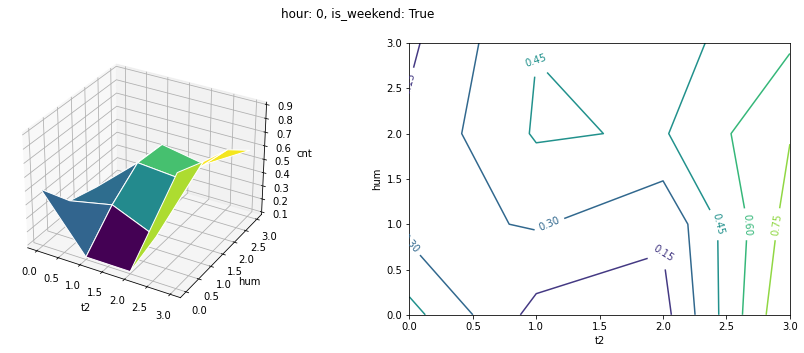

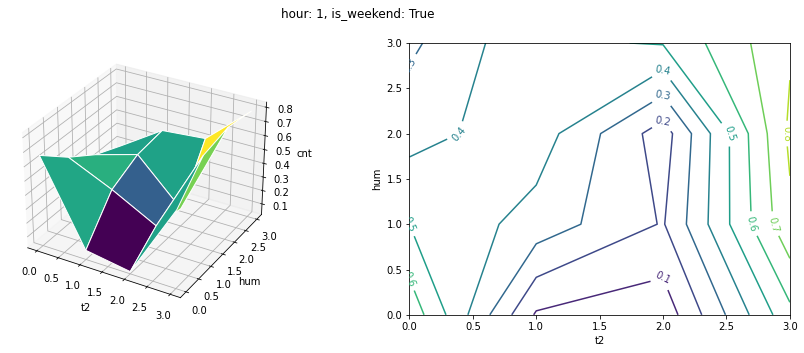

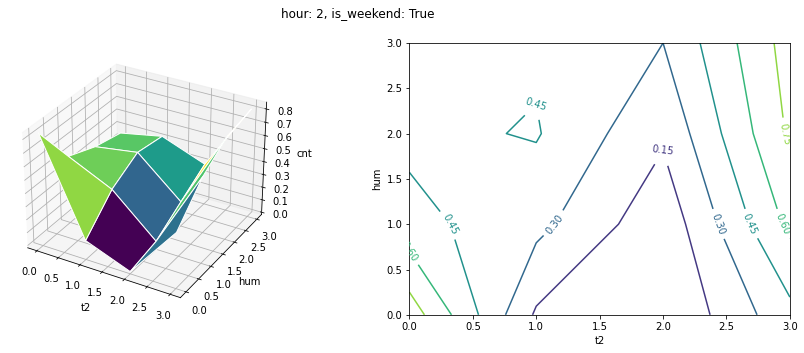

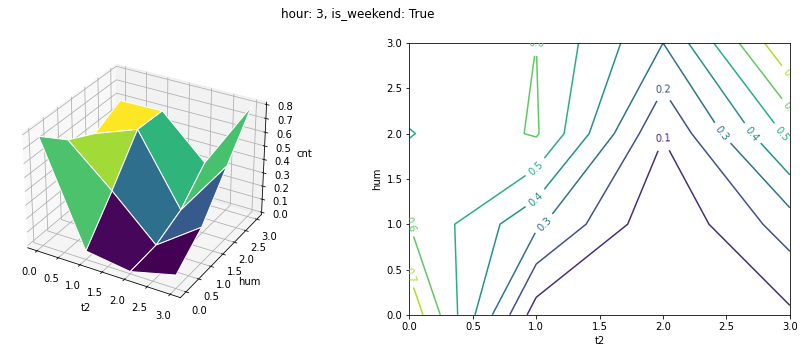

In [93]:
for i in range(4):
  plot3d(range(4), range(4), np.array(answers[i]),
         't2', 'hum', 'cnt', f'hour: {i}, is_weekend: True')

TODO comments

In [94]:
answers = [[[] for _ in range(4)] for _ in range(4)]
for t2 in range(4):
  for hum in range(4):
    for hour in range(4):
      evidence = {"t2": t2, "hum": hum, 'is_weekend': False, 'hour': hour}
      answers[t2][hum].append(inference.query(["cnt"], evidence, show_progress=False).values[1])

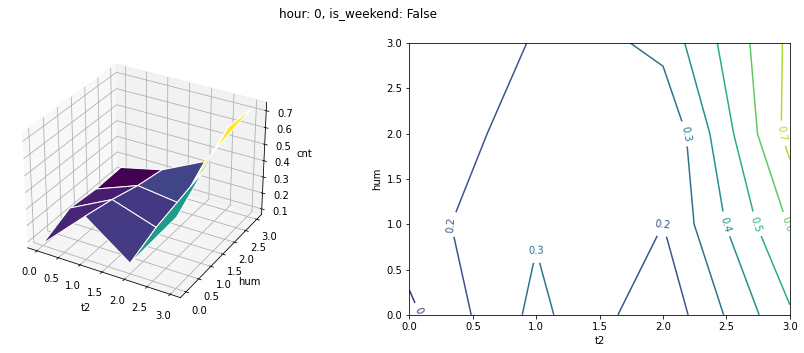

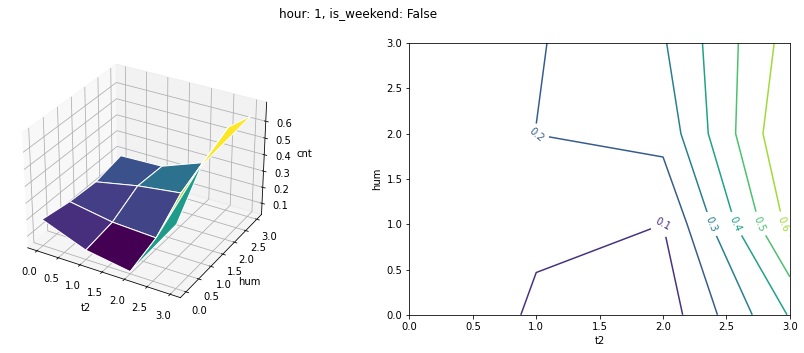

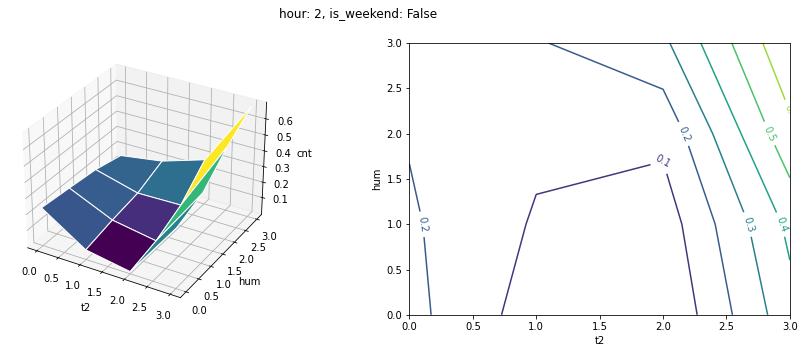

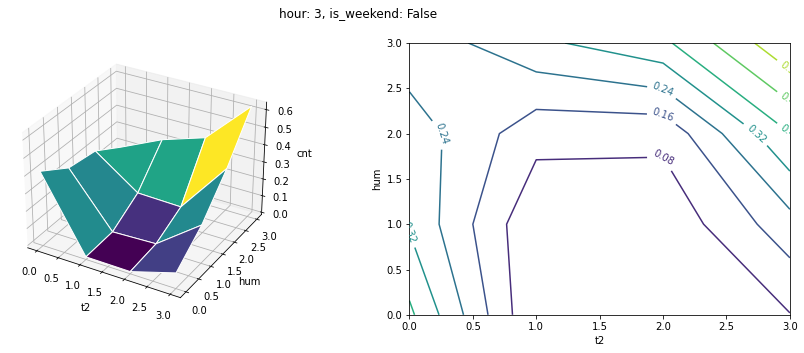

In [95]:
for i in range(4):
  plot3d(range(4), range(4), np.array(answers[i]),
         't2', 'hum', 'cnt', f'hour: {i}, is_weekend: False')

### HC constrained model

In the base model the features that directly influence On_chart are:
 - duration_ms, range {0,...,4},
 - instrumentalness, range {0,1},
 - speechiness, range {0,...,4},
 - valence, range {0,...,4}.

Let's see how they influence it.

In [ ]:
ve = inferences['HC constraint model']
answers_duration = []
answers_instrumental = []
answers_speech = []
answers_valence = []
for score in range(5):
  for feature, answers in [('duration_ms', answers_duration),
                            ('speechiness', answers_speech),
                            ('valence', answers_valence)]:
    evidence = {feature : score}
    answers.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])
for score in range(2):
  evidence = {"instrumentalness": score}
  answers_instrumental.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])

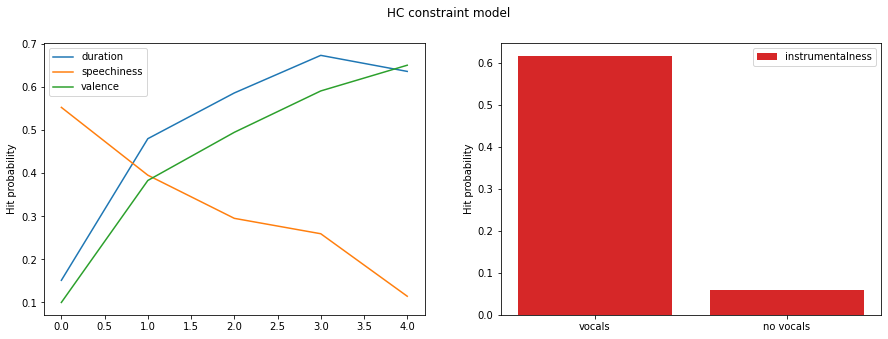

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
fig.suptitle(f"HC constraint model")
ax.set_ylabel('Hit probability')
ax.plot(answers_duration, label='duration')
ax.plot(answers_speech, label='speechiness')
ax.plot(answers_valence, label='valence')
ax.legend()
ax2 =axes[1]
ax2.bar(range(2), answers_instrumental, label='instrumentalness', color='C3')
ax2.legend()
ax2.set_xticks(range(2))
ax2.set_xticklabels(['vocals', 'no vocals'])
ax2.set_ylabel('Hit probability')
fig.savefig('query1')

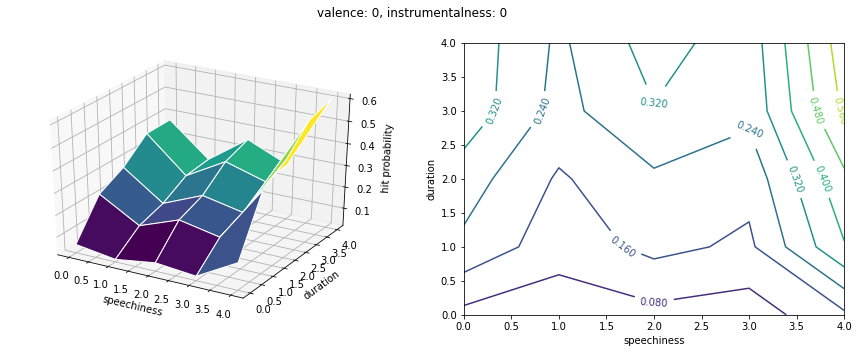

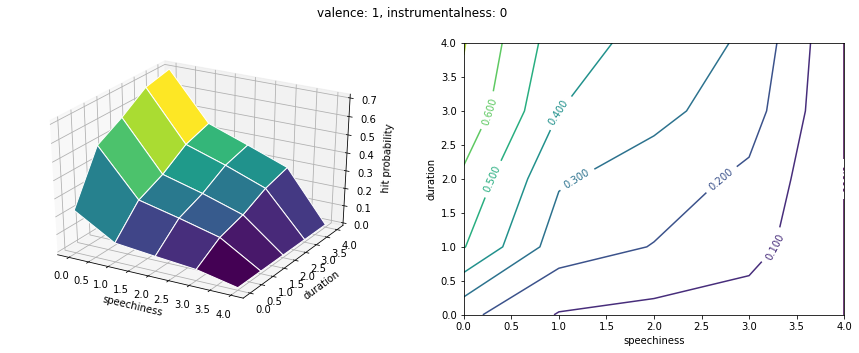

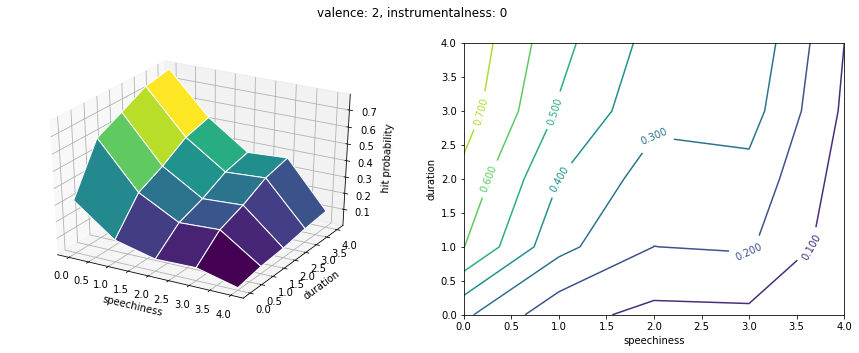

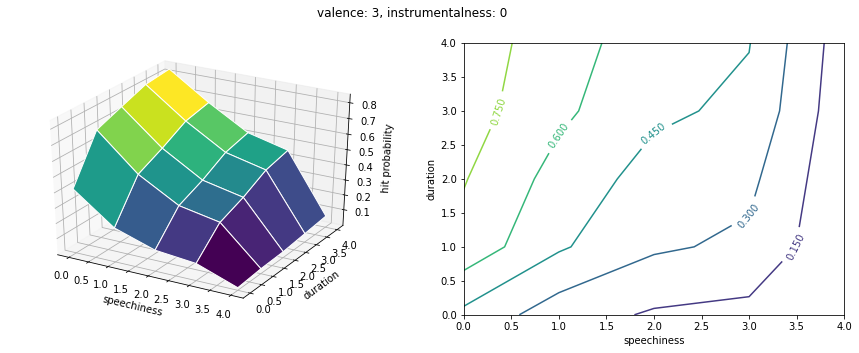

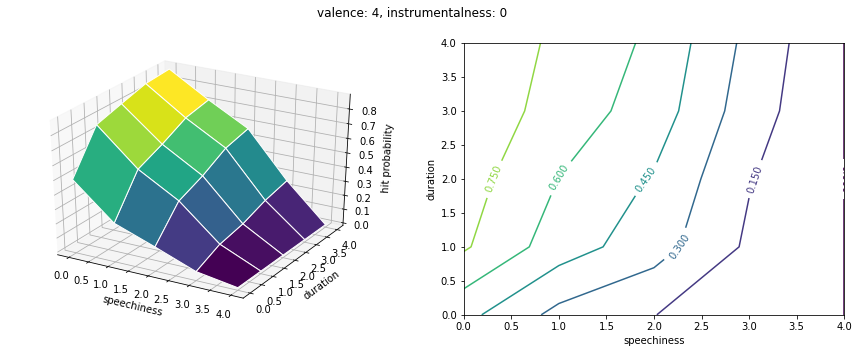

In [ ]:
answers = [[[] for _ in range(5)] for _ in range(5)]
for valence in range(5):
  for duration in range(5):
    for speechiness in range(5):
      evidence = {"duration_ms": duration, "speechiness": speechiness, 'instrumentalness': 0, 'valence': valence}
      answers[valence][duration].append(ve.query(["On_chart"], evidence, show_progress=False).values[1])

for i in range(5):
  plot3d(range(5), range(5), np.array(answers[i]),
         'speechiness', 'duration', 'hit probability', f'valence: {i}, instrumentalness: 0')

What said for the previous model still holds, but now we can see that long tracks (last cinquile) have the highest probability.

### HC constrained model, with inverted arrows

In this model the features that directly influence On_chart are:
 - duration_ms, range {0,...,4},
 - instrumentalness, range {0,1},
 - speechiness, range {0,...,4},
 - valence, range {0,...,4}.
 - acousticness, range {0,...,4},
 - mode, range {0,1}

Let's see how they influence it.

In [ ]:
ve = inferences['HC constraint model, with inverted arrows']
answers_duration = []
answers_instrumental = []
answers_speech = []
answers_valence = []
answers_acoustic = []
answers_mode = []
for score in range(5):
  for feature, answers in [('duration_ms', answers_duration),
                            ('speechiness', answers_speech),
                            ('valence', answers_valence),
                           ('acousticness', answers_acoustic)]:
    evidence = {feature : score}
    answers.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])
for score in range(2):
  evidence = {"instrumentalness": score}
  answers_instrumental.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])
  evidence = {'mode' : score}
  answers_mode.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])


[]

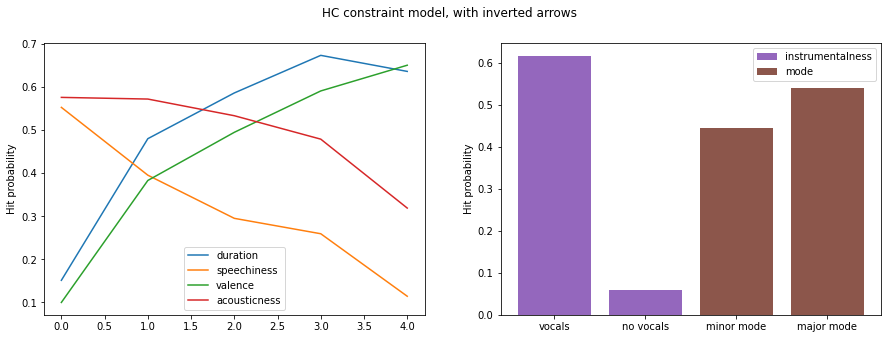

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
fig.suptitle(f"HC constraint model, with inverted arrows")
ax.set_ylabel('Hit probability')
ax.plot(answers_duration, label='duration')
ax.plot(answers_speech, label='speechiness')
ax.plot(answers_valence, label='valence')
ax.plot(answers_acoustic, label='acousticness')
ax.legend()
ax2 = axes[1]
ax2.bar(range(2), answers_instrumental, label='instrumentalness', color='C4')
ax2.bar(range(2,4), answers_mode, label='mode', color='C5')
ax2.legend()
ax2.set_xticks(range(4))
ax2.set_xticklabels(['vocals', 'no vocals', 'minor mode', 'major mode'])
ax2.set_ylabel('Hit probability')
plt.plot()

This model seems to sum up the other two models and also it tells us that major mode tracks have a bit more chance to be hits, but it semmes to be negligible.

We have only analyzed direct influence factors, but the generated models tell us also about other features, with a lot of possible combination. For example we could want to know if there is a best tempo to choose if we want to public on Spotify an angry (valence=0) metal (energy=4, loudness=4, acousticness=0, speechiness=0) song with vocals (instrumentalness=0) and we wanto it to become an hit. What if we want it to be danceable?

In [ ]:
ve = inferences['HC constraint model, with inverted arrows']
answers_hit = []
answers_dance = []
for tempo in range(5):
  evidence = {'tempo': tempo, 'valence': 0, 'energy': 4, 'loudness': 4, 'acousticness': 0, 'speechiness': 0, 'instrumentalness': 0}
  answers_hit.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])
  answers_dance.append(ve.query(["danceability"], evidence, show_progress=False).values)

[]

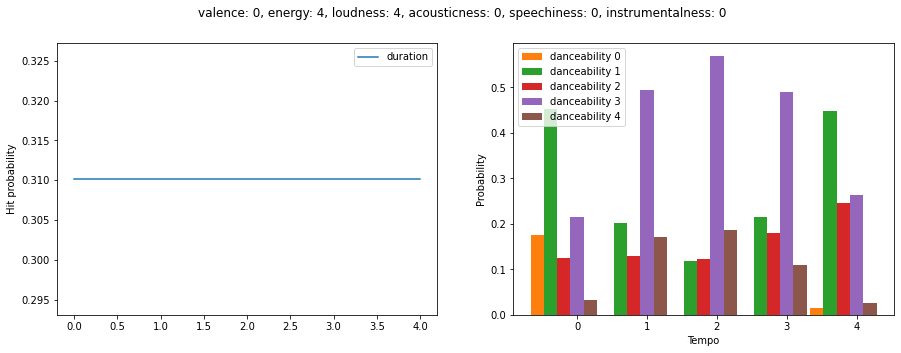

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
fig.suptitle(f"valence: 0, energy: 4, loudness: 4, acousticness: 0, speechiness: 0, instrumentalness: 0")
ax.set_ylabel('Hit probability')
ax.plot(answers_hit, label='duration')
ax.legend()
ax2 =axes[1]
for i in range(5):
  ax2.bar(np.arange(5) + (i-3)*0.19, list(map(lambda x: x[i], answers_dance)), 0.19, label=f"danceability {i}", color=f'C{i+1}')
ax2.legend()
ax2.set_xticks(range(5))
ax2.set_ylabel('Probability')
ax2.set_xlabel('Tempo')
plt.plot()

The answers is that there is not a best possible tempo to make the song a hit, since it is influent, but if we choose a tempo in the second cinquile at least we have the higest probability to make it danceable.